In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import dianna

from pathlib import Path
from joblib import load
from matplotlib import pyplot as plt
from dianna import visualization
from dianna.utils.onnx_runner import SimpleModelRunner
from IPython.display import display

np.random.seed(0)
root_dir = Path(dianna.__file__).parent

In [2]:
## TODO Colab setup

In [3]:
## TODO
# Download model from zenodo
parent_in_path = "/home/sarah/temp/ecoextreml/emulator_data/model"
model_path = f"{parent_in_path}/model_LEtot.onnx"


In [4]:
def preprocess(data):
    data_reshaped = data
    if len(data.shape) == 1:
        data_reshaped = data.reshape(1,-1)
    return data_reshaped.astype(np.float32)
    
runner = SimpleModelRunner(model_path, preprocess_function=preprocess)

In [5]:
model_input_path = "/home/sarah/temp/ecoextreml/emulator_data/NL/model_input_2014-1-31_2014-02-05_NL.nc"
model_input = xr.open_dataset(model_input_path)

input_vars = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]

# select input/output data 
input_ds = model_input[input_vars]
output_vars = ['LEtot']

In [6]:
def prepare_data(data):
    df_features = data.to_dataframe().reset_index().drop(columns=["time", "longitude", "latitude"])
    
    # Convert the nan value as 0 for the calculation
    df_features = df_features.fillna(0)
    
    return df_features.to_numpy()

In [7]:
timeseries_data = input_ds.sel(latitude=(52.36),longitude=(4.90), method='nearest')
features = prepare_data(timeseries_data)

In [8]:
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

In [9]:
%%time
data_instance = features[0, :].reshape(1, -1)
background_data = np.zeros(data_instance.shape)
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                    feature_names=input_vars, silent=True)

CPU times: user 2.93 s, sys: 822 ms, total: 3.75 s
Wall time: 2.45 s


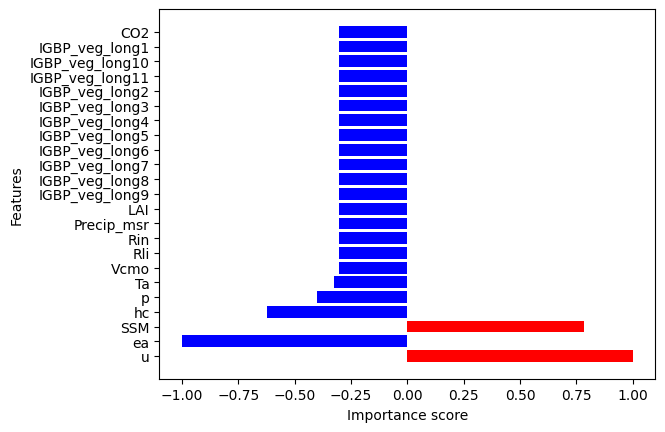

In [10]:
heat_map = normalize(explanation)[0]
_ = visualization.plot_tabular(heat_map, input_vars, num_features=len(input_vars))

In [11]:
import dianna.methods.kernelshap_tabular as kt
# this is needed due to the implementations of kwargs

In [12]:
# loop over time series
explanations = np.zeros(features.shape)
for time in range(features.shape[0]):
    data_instance = features[time].reshape(1, -1)
    background_data = np.zeros(data_instance.shape)
    explainer = kt.KERNELSHAPTabular(training_data=background_data, mode ='regression',feature_names=input_vars)
    explanation = explainer.explain(runner, input_tabular=data_instance, silent=True)
    explanations[time] = normalize(explanation)

print("Dianna is done!") 

Dianna is done!


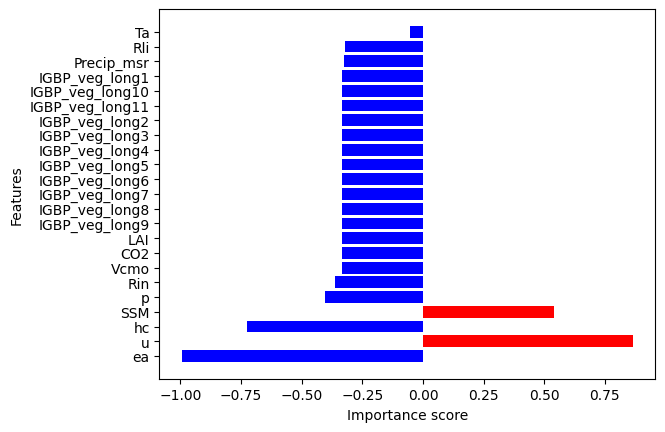

In [14]:
heat_map = explanations.mean(axis=0)
_ = visualization.plot_tabular(heat_map, input_vars, num_features=len(input_vars))

In [15]:
predictions = runner(features)

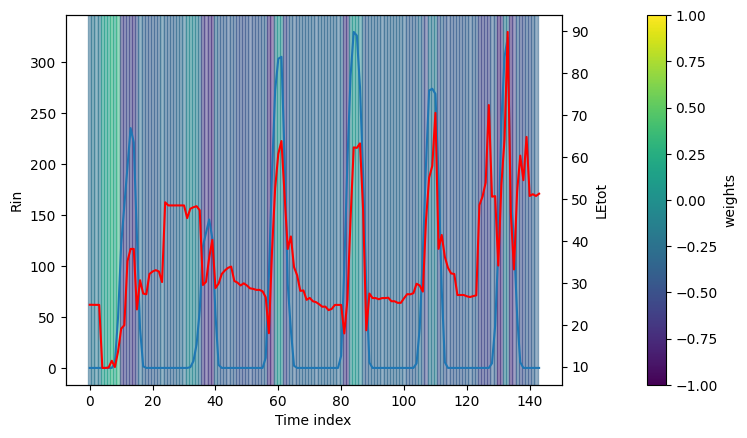

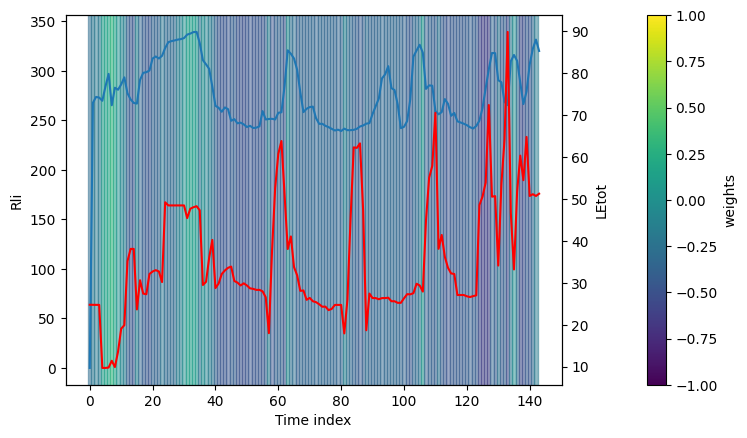

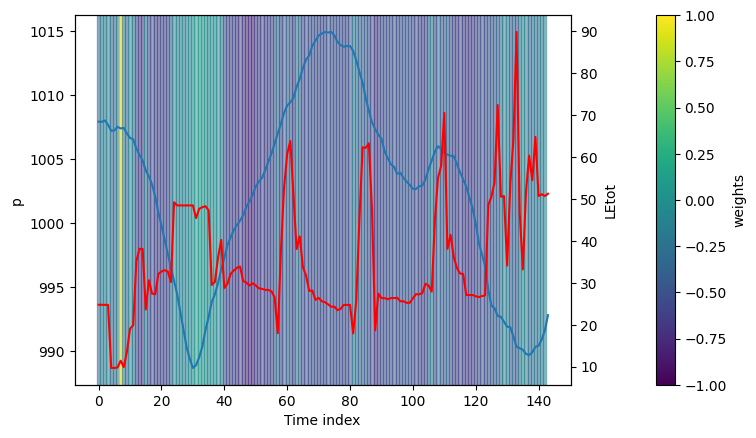

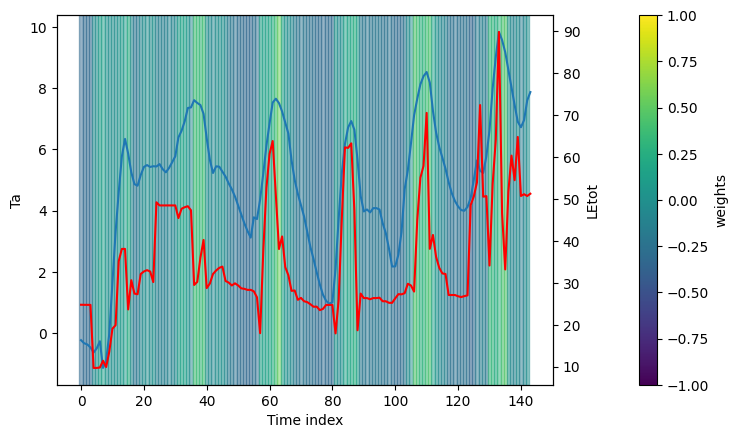

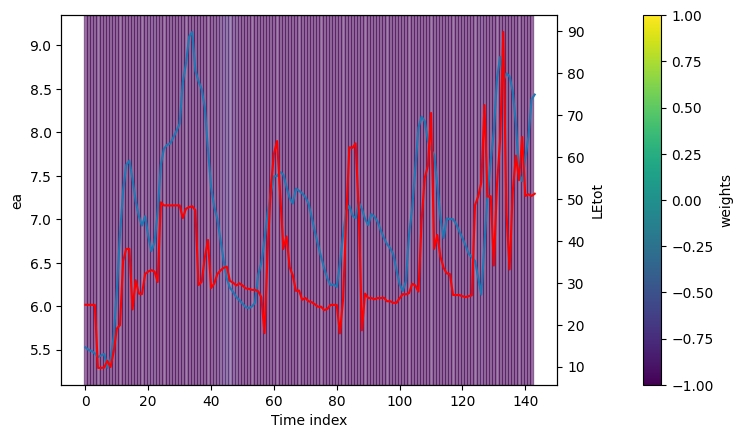

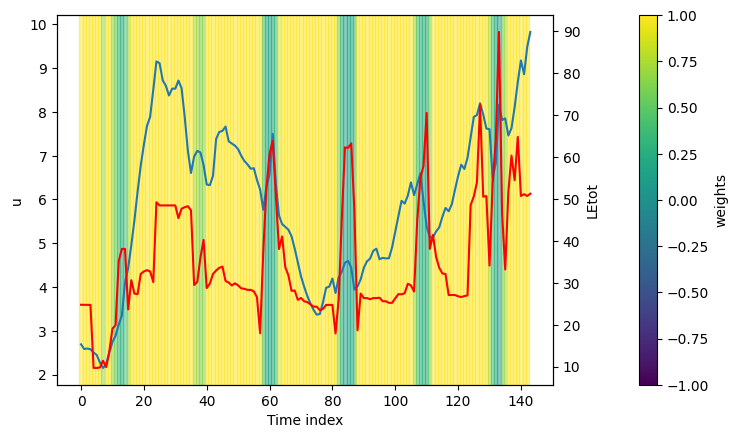

In [16]:
for indx in range(6):
    heatmap_channel = explanations[:, indx]
    segments = []
    for i in range(len(heatmap_channel) - 1):
        segments.append({
            'index': i,
            'start': i - 0.5,
            'stop': i + 0.5,
            'weight': heatmap_channel[i]})
    
    fig, axs = visualization.plot_timeseries(range(len(heatmap_channel)), features[:,indx],
                                  segments, x_label="Time index", y_label=input_vars[indx], show_plot=False)
    
    axs2 = axs[0].twinx()
    axs2.set_ylabel(output_vars[0])
    axs2.plot(predictions, color='r') 
    
    # change position of colorbar
    cbar_ax = fig.axes[-1]
    cbar_pos = cbar_ax.get_position()
    new_pos = [cbar_pos.x0 - 0.25, cbar_pos.y0, cbar_pos.width, cbar_pos.height]
    cbar_ax.set_position(new_pos)
    
    display(fig)